# Check to see if we're running in Colab (versus local server)

In [29]:
try:
    from google.colab import drive

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

if IN_COLAB:
    print("We're running Colab")

We're running Colab


# Mount the Google Drive (if we're in Colab), switch current directory to a directory on the Google Drive
- we will (optionally) create the specified directory on the Google Drive if it doesn't exist

- navigate to our Harvard Capstone shared folder -> right-click -> organize -> add shortcut -> all locations -> add "My Drive"

In [30]:
if IN_COLAB:
    # Mount the Google Drive at mount
    mount = "/content/gdrive"
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    import os

    drive_root = mount + "/My Drive/Harvard Capstone/Modeling/UNet"

    # Create drive_root if it doesn't exist
    # create_drive_root = True
    # if create_drive_root:
    #  print("\nColab: making sure ", drive_root, " exists.")
    #  os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root

Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Colab: Changing directory to  /content/gdrive/My Drive/Harvard Capstone/Modeling/UNet
/content/gdrive/.shortcut-targets-by-id/1eW3hLH0IEClxPvf9Y2NP-NAtoaEftFcx/UNet


# Work with files on the Google Drive
- existing files
- upload files to Google Drive (as per normal)
- load files from external source

In [31]:
# Verify we're in the correct working directory
%pwd

'/content/gdrive/.shortcut-targets-by-id/1eW3hLH0IEClxPvf9Y2NP-NAtoaEftFcx/UNet'

## Verify that imports (of modules on the Google Drive) work

In [32]:
import glob, json, os
import datetime as dt
import datetime
from IPython.display import HTML

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy import ndimage
from scipy.ndimage import sobel, binary_erosion, label
import skimage
import numba
import scipy

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Conv2DTranspose,
    concatenate,
    Input,
    Lambda,
    Activation,
    Layer,
    Add,
    Reshape,
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [33]:
# Install the extra library for interactive matplotlib plots
!pip install mpld3

# Set configuration constants

In [34]:
data_root = "ims_netcdf_1km_cropped_2_000km_window_74lat_-170lon/"
if not IN_COLAB:
    data_root = os.path.join("..", "data", data_root)
    tf.config.set_visible_devices([], "GPU")
WINDOW_SIZE = 2000  # km

In [35]:
batch_size = 1
test_batch_size = 2
dim = (WINDOW_SIZE, WINDOW_SIZE, 3)

# Data loading and processing functions

In [36]:
# Define a function to load a single .nc file for a given year and day
def load_nc_file(year, day) -> xr.Dataset:
    """Loads the cropped, grid-corrected netcdf files on the Beaufort Sea with 74,0lat_-170,0lon"""
    # Generate the file path based on the year and day
    file_path = os.path.join(
        data_root,
        str(year),
        f"ims{year}{day:03d}_1km_v1.3_grid{WINDOW_SIZE}_74,0lat_-170,0lon.nc",
    )

    # Load the .nc file using xarray
    with xr.open_dataset(file_path) as dataset:
        return dataset

In [ ]:
def load_sie_data(year, day) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    return load_nc_file(year, day).IMS_Surface_Values[0].values.copy()

In [ ]:
def load_binary_sie_data(year, day) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    sie = load_sie_data(year, day)
    binary_sie = sie.copy()

    # Sea and Lake Ice is treated as 1
    binary_sie[sie == 3] = 1

    binary_sie[sie != 3] = 0
    binary_sie[sie == 2] = 0
    binary_sie[sie == 4] = 0
    return binary_sie

In [ ]:
def trinarize_data(sie: np.array) -> np.array:
    """
    New SIE:
    0: Open water/out of bounds
    1: Sea ice or lake ice (lake mask not applied)
    2: Land
    """
    trinary_sie = sie.copy()
    trinary_sie[sie != 3] = 0

    # Sea and Lake Ice is treated as 1
    trinary_sie[sie == 3] = 1

    # Land and Snow-Covered Land is sent to 2.
    trinary_sie[sie == 2] = 2
    trinary_sie[sie == 4] = 2
    return trinary_sie

In [ ]:
def binary_land_not_land(sie: np.array) -> np.array:
    """
    Create a binary land/not land mask from the multiclass (5 classes) IMS cropped data.
    Assumes classes 2, 4 in the input SIE correspond to Land and Snow Covered Land.

    New SIE:
    0: Open water/out of bounds, Sea ice or lake ice (lake mask not applied)
    1: Land
    """
    binary_land_not_land = np.zeros(sie.shape)

    # Land and Snow-Covered Land is sent to 1.
    binary_land_not_land[sie == 2] = 1
    binary_land_not_land[sie == 4] = 1
    return binary_land_not_land

In [ ]:
def load_binary_n_day_chunk(year: int, day: int, n=4) -> np.array:
    """
    Return binary ice/not ice np.array with shape (height, width, channels).

    Does NOT wrap years or account for missing days.
    Starts n_day chunk at specified day, year.

    Returns:
        np.array: shape (sie_y_shape, sie_x_shape, n_day)
    """
    sie_chunk = []
    for new_day in range(day, day + n):
        sie = load_binary_sie_data(year, new_day)
        sie_chunk.append(sie)

    assert len(sie_chunk) == n
    # Use np.stack to stack the individual 2D arrays along a new third axis, resulting in (height, width, channels)
    return np.stack(sie_chunk, axis=-1)

In [ ]:
def load_n_day_chunk(year: int, day: int, n=4) -> np.array:
    """
    Return np.array with shape (height, width, channels).

    Does NOT wrap years or account for missing days.
    Starts n_day chunk at specified day, year.

    Returns:
        np.array: shape (sie_y_shape, sie_x_shape, n_day)
    """
    sie_chunk = []
    for new_day in range(day, day + n):
        sie = trinarize_data(load_sie_data(year, new_day))
        sie_chunk.append(sie)

    assert len(sie_chunk) == n
    # Use np.stack to stack the individual 2D arrays along a new third axis, resulting in (height, width, channels)
    return np.stack(sie_chunk, axis=-1)

## Edge Detection Functions

In [ ]:
def image_batch_to_binary_edge_image(image_batch: np.array) -> np.array:
    """
    Perform Sobel edge detection on an (optionally batched) image
    Image has dimension (batch_size, window_size, window_size).
    """
    binary_ice_no_ice = np.round(image_batch)

    try:
        assert np.allclose(
            np.unique(binary_ice_no_ice), np.array([0, 1])
        ), f"Expected input image batch to have values between 0 and 1, got range {np.unique(binary_ice_no_ice)} instead"
    except ValueError as e:
        print(np.unique(image_batch))
        print(
            f"Expected input image batch to have values between 0 and 1, got range {np.unique(binary_ice_no_ice)} instead"
        )
        raise ValueError(e)

    # Sobel expects input to have dimension (batch, window, window, 1)
    if len(binary_ice_no_ice.shape) != 4:
        batch_tensor = tf.expand_dims(tf.convert_to_tensor(binary_ice_no_ice), axis=-1)

    sobel_edges = tf.image.sobel_edges(batch_tensor)
    sobel_x = sobel_edges[..., 0]
    sobel_y = sobel_edges[..., 1]

    # Apply absolute value, threshold, and sum the results of x and y edges
    edges_x = tf.cast(tf.square(sobel_x) >= 0.01, tf.float32)
    edges_y = tf.cast(tf.square(sobel_y) >= 0.01, tf.float32)
    edge_magnitudes = edges_x + edges_y
    return edge_magnitudes.numpy()

In [ ]:
def process_binary_edge_image_into_coordinates(activated: np.array) -> np.array:
    """
    Takes a numpy array of edge detected pixels (not SIE).
    Cannot take in a tensorflow tensor, input array must be between 0 and 1.
    Input array is the result of running edge-detection on Ice/No Ice array.

    Parameters:
        activated: Numpy array with >= 0.5 indicating sea-ice edge.

    Returns:
        numpy array of integer indices in input array corresponding to edge pixels. Of shape (N Edges, 2)

    """
    edge_coordinates = []
    for i in range(activated.shape[-2]):
        edges = np.where(np.round(activated[:, :, i, :]) >= 1)
        x, y = edges[0], edges[1]
        edge_coordinates.append(np.stack((x, y), axis=-1))

    return edge_coordinates

In [ ]:
@numba.jit(nopython=True)
def average_and_rms_ice_edge_displacement(observed_edges, model_edges):
    """
    Calculate both the average (D_AVG_IE) and RMS ice edge displacement (D_RMS_IE) between observed and model ice edges.
    Credit: Validation metrics for ice edge position forecasts, Melsom et al., 2019.

    Parameters:
    - observed_edges: numpy array of shape (N, 2), where N is the number of observed ice edge points,
      and each point is represented by its (x, y) coordinates.
    - model_edges: numpy array of shape (M, 2), where M is the number of model ice edge points,
      and each point is represented by its (x, y) coordinates.

    Returns:
    - D_AVG_IE: The average displacement between the observed and model ice edges.
    - D_RMS_IE: The root mean square displacement between the observed and model ice edges.
    """

    # Initialize lists to store minimum distances for each point
    observed_to_model_distances = []
    model_to_observed_distances = []

    # Calculate distances from each observed point to the nearest model point
    for obs_point in observed_edges:
        obs_point_broadcasted = np.full(
            shape=model_edges.shape[0],
            fill_value=obs_point,
        )
        distances = np.sqrt(np.sum((model_edges - obs_point_broadcasted) ** 2, axis=1))
        observed_to_model_distances.append(np.min(distances))

    # Calculate distances from each model point to the nearest observed point
    for model_point in model_edges:
        model_point_broadcasted = np.full(
            shape=observed_edges.shape[0],
            fill_value=model_point,
        )
        distances = np.sqrt(
            np.sum((observed_edges - model_point_broadcasted) ** 2, axis=1)
        )
        model_to_observed_distances.append(np.min(distances))

    # Calculate the average displacement
    avg_displacement = (
        sum(observed_to_model_distances) / len(observed_to_model_distances)
        + sum(model_to_observed_distances) / len(model_to_observed_distances)
    ) / 2

    # Calculate the root mean square displacement
    rms_displacement = np.sqrt(
        (
            sum([dist**2 for dist in observed_to_model_distances])
            + sum([dist**2 for dist in model_to_observed_distances])
        )
        / (len(observed_to_model_distances) + len(model_to_observed_distances))
    )

    return avg_displacement, rms_displacement

# Examine Edges for Truth Data




In [ ]:
year = 2023
day = 150
n = 4

In [ ]:
sie_chunk = load_binary_n_day_chunk(year=year, day=day, n=4)

In [ ]:
sie_binary_edge_img = image_batch_to_binary_edge_image(sie_chunk)

In [ ]:
edge_coordinate_list = process_binary_edge_image_into_coordinates(sie_binary_edge_img)

In [ ]:
sie_chunk.shape

(2000, 2000, 4)

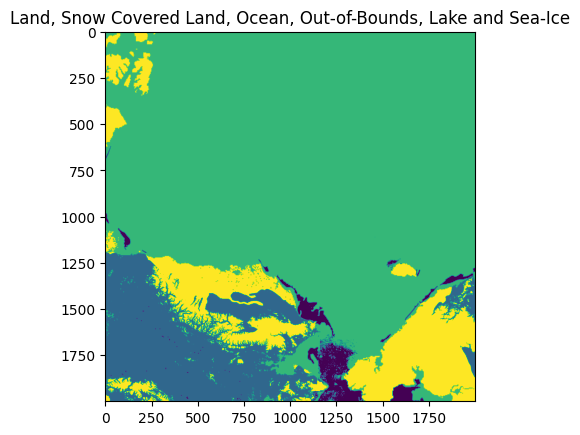

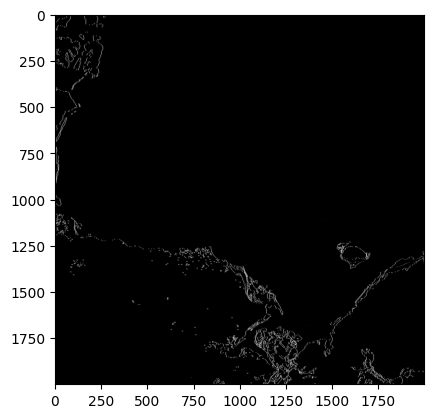

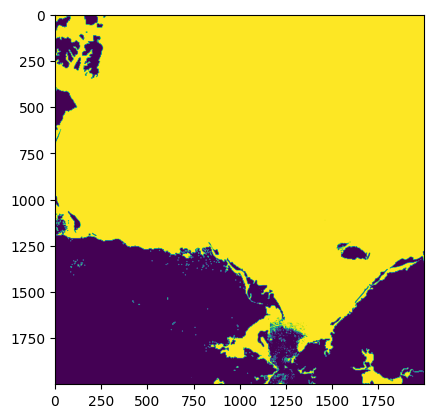

In [ ]:
data = load_nc_file(year, day)
multiclass_sie = load_sie_data(year, day)
binary_ice_target_img = load_binary_sie_data(year=year, day=day)

# Original creat
plt.title("Land, Snow Covered Land, Ocean, Out-of-Bounds, Lake and Sea-Ice")
plt.imshow(multiclass_sie)
plt.show()

plt.imshow(sie_binary_edge_img[:, :, -1], cmap="gray")
plt.show()

plt.imshow(binary_ice_target_img, cmap="viridis")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins

fig, ax = plt.subplots()
ax.grid(True, alpha=0.3)

plt.imshow(sie_binary_edge_img[:, :, -1], cmap="gray")
mpld3.display()

In [ ]:
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins

fig, ax = plt.subplots()
ax.grid(True, alpha=0.3)

plt.imshow(sie_chunk[:, :, 0], cmap="gray")
mpld3.display()

In [ ]:
i = 0.1
contours = skimage.measure.find_contours(sie_chunk[:, :, 0], i)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.grid(True, alpha=0.3)

ax.imshow(sie_chunk[:, :, 0], cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

mpld3.display()

# Sobel Image Eval Pipeline

Provide a path to a folder with the .npy predictions

In [ ]:
prediction_directory = "./model_checkpoints/jbacon/unet_sobel_with_sie_10:10PM_March_30_2024_2000km/model_test_predictions_669"
model_predictions = glob.glob(prediction_directory + "/*.npy")

In [ ]:
model_predictions[0]

'./model_checkpoints/jbacon/unet_sobel_with_sie_10:10PM_March_30_2024_2000km/model_test_predictions_669/pred_2021_161.npy'

## For sobel output:

In [ ]:
model_prediction_results = {}
for i in range(len(model_predictions)):
    extracted_string = model_predictions[i].split("/")[-1].split("_")
    year = int(extracted_string[1])
    day = int(extracted_string[2][:-4])

    model_sie = np.round(np.load(model_predictions[i])[:, :, :, 0])
    true_sie = load_binary_sie_data(year=year, day=day)

    true_sie_edges = process_binary_edge_image_into_coordinates(
        image_batch_to_binary_edge_image(np.expand_dims(true_sie, axis=0))
    )
    model_sie_edges = process_binary_edge_image_into_coordinates(
        image_batch_to_binary_edge_image(model_sie)
    )
    print(model_sie_edges)
    break

    avg, rms = average_and_rms_ice_edge_displacement(true_sie_edges, model_sie_edges)

    model_prediction_results[(year, day)] = {"avg": avg, "rms": rms}

[array([[   0,   31],
       [   0,   32],
       [   0,   35],
       [   0,   36],
       [   0,   39],
       [   0,   40],
       [   0,   79],
       [   0,   80],
       [   0,  135],
       [   0,  136],
       [   0,  215],
       [   0,  216],
       [   0,  231],
       [   0,  232],
       [   0,  251],
       [   0,  252],
       [   0,  395],
       [   0,  396],
       [   0,  415],
       [   0,  416],
       [   0,  419],
       [   0,  420],
       [   0,  631],
       [   0,  632],
       [   0,  853],
       [   0,  854],
       [   0,  855],
       [   0,  858],
       [   0,  859],
       [   0,  863],
       [   0,  864],
       [   0,  865],
       [   0,  867],
       [   0,  897],
       [   0,  899],
       [   0, 1013],
       [   0, 1014],
       [   0, 1015],
       [   0, 1020],
       [   0, 1021],
       [   0, 1023],
       [   0, 1024],
       [   0, 1026],
       [   0, 1091],
       [   0, 1092],
       [   0, 1155],
       [   0, 1156],
       [   0

In [ ]:
np.unique(np.round(model_sie[0, :, :, 0]))

array([0., 1.], dtype=float32)